# PME3481 - Controle e Aplicações

## Síntese pelo LQR

In [1]:
import numpy as np
import scipy.linalg as la
import matplotlib.pyplot as plt
import control as ctrl
import warnings

In [2]:
warnings.simplefilter("ignore")  # Ignore all warnings

### Estabilidade segundo Lyapunov

In [3]:
def check_stability(A):
    """
    Check system stability using Lyapunov's method.
    
    Parameters:
        A (numpy.ndarray): State matrix.
    
    Returns:
        stable (bool): True if the system is stable, False otherwise.
    """
    # Solve the Lyapunov equation A.T @ P + P @ A = -I
    P = la.solve_lyapunov(A.T, -np.eye(A.shape[0]))
    
    # Check if the solution is positive definite
    stable = np.all(np.linalg.eigvals(P) > 0)
    return stable

### Definição da Síntese pelo LQR

In [4]:
def lqr(A, B, Q, R):
    """    
    Parameters:
        A (numpy.ndarray): State matrix.
        B (numpy.ndarray): Input matrix.
        Q (numpy.ndarray): State cost matrix.
        R (numpy.ndarray): Input cost matrix.
    
    Returns:
        K (numpy.ndarray): Feedback gain matrix.
    """
    P = la.solve_continuous_are(A, B, Q, R)

    # Calculate the feedback gain matrix
    K = np.linalg.inv(R) @ B.T @ P
    return K

Definição do modelo

In [5]:
Xcm = 1.052
Xpe = 0.261
L = 3.304
Df = 0.127
Tlin = 230.57
Izz = 15.07
M = 23.545
g = 9.8055
dar = 1.091
Cd = 0.432
Vxlin = -10.0

In [6]:
# X = [x,y,theta,xp,yp,thetap]
# Xp = [xp,yp,thetap,xpp,ypp,thetapp]
A = np.array([[0, 0, 0, 1, 0, 0],
              [0, 0, 0, 0, 1, 0],
              [0, 0, 0, 0, 0, 1],
              [0, 0, 0, (-1/M)*(Vxlin *dar*Cd*((Df/2)**2*np.pi)), 0, 0],
              [0, 0, (1/M)*(-M*g-(1/2)*Vxlin**2*dar*Cd*(np.pi*(Df/2)**2)), 0, 0, 0],
              [0, 0, (1/Izz)*((1/2)*Vxlin**2*dar*Xpe*Cd*(np.pi*(Df/2)**2)), 0, 0, 0]])
# u = [T,tau]
B = np.array([[0, 0],
              [0, 0],
              [0, 0],
              [1/M, 0],
              [0, -Tlin/M],
              [0, -Tlin*Xcm/Izz]])

C = np.array([[ 0, 0, 1, 0, 0, 0],
              [ 0, 0, 0, 1, 0, 0],
              [ 0, 0, 0, 0, 1, 0]])

D = np.array([[ 0, 0],
              [ 0, 0],
              [ 0, 0]])

# Define Q, R matrices (cost matrices)
# Define state cost matrix Q
Q = np.diag([10, 10, 10, 1, 1, 1])  # Higher importance to position-related states

# State cost matrix
R = np.diag([0.1, 0.1])  # Moderate penalty for control inputs
# Check system stability

stable = check_stability(A)
if stable:
    print("The system is stable according to Lyapunov's method.")
else:
    print("The system is unstable according to Lyapunov's method.")

# Compute LQR controller
K = lqr(A, B, Q, R)

np.set_printoptions(precision=3, suppress=True)
print("LQR Feedback Gain Matrix (K):")
print(K)

The system is unstable according to Lyapunov's method.
LQR Feedback Gain Matrix (K):
[[ 10.     -0.      0.     21.989  -0.      0.   ]
 [ -0.     10.    -37.952  -0.      9.343  -9.887]]


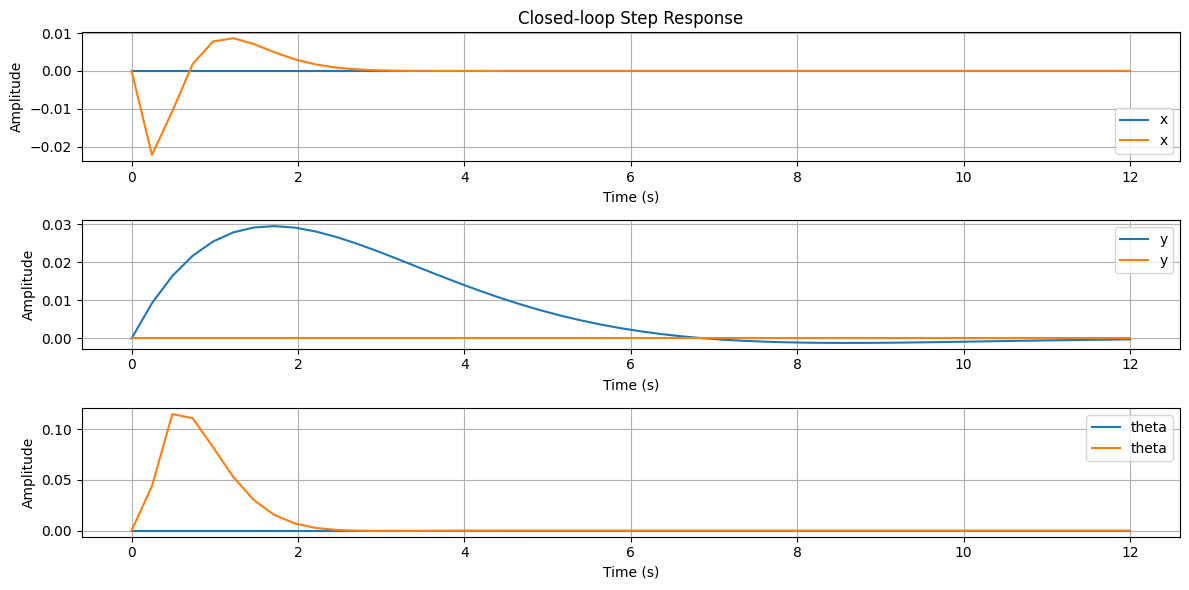

In [7]:
# Compute closed-loop system
Acl = A - np.dot(B, K)
syscl = ctrl.ss(Acl, B, C, D)

# Plot the step response
plt.figure(figsize=(12, 6))

# Plot x response
plt.subplot(3, 1, 1)
t = np.linspace(0, 12)  # Time range from 0 to 12 seconds
t, y = ctrl.step_response(syscl, T=t)
plt.plot(t, y[0].T, label='x')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.title('Closed-loop Step Response')
plt.legend()
plt.grid()

# Plot y response
plt.subplot(3, 1, 2)
plt.plot(t, y[1].T, label='y')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.legend()
plt.grid()

# Plot theta response
plt.subplot(3, 1, 3)
plt.plot(t, y[2].T, label='theta')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()